### Pràctica 1. Regressió

Maria Pallejà, Pablo Ruiz i Clara Sorolla

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import *
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures

In [2]:
np.set_printoptions(precision=3, suppress=True)

**Load dataset**

In [3]:
df_raw = pd.read_csv('/work/Life Expectancy Data.csv')

In [4]:
df_raw.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [5]:
df_raw.rename(
    columns={
        'Life expectancy ': 'Life expectancy',
        'infant deaths': 'Infant deaths',
        'percentage expenditure': 'Percentage expenditure',
        'Measles ': 'Measles',
        ' BMI ': 'BMI',
        'under-five deaths ': 'Under-five deaths',
        'Diphtheria ': 'Diphtheria',
        ' HIV/AIDS': 'HIV/AIDS',
        ' thinness  1-19 years': 'Thinness 10-19 years',
        ' thinness 5-9 years': 'Thinness 5-9 years'
    },
    inplace=True
)

In [6]:
objective = 'Life expectancy'

#### Apartat C

**Clean dataset**

In [7]:
pd.concat(
    [df_raw.dtypes, df_raw.isnull().sum()],
    axis=1,
    keys=['dtypes', 'NaNs']
)

,dtypes,NaNs
Country,object,0
Year,int64,0
Status,object,0
Life expectancy,float64,10
Adult Mortality,float64,10
Infant deaths,int64,0
Alcohol,float64,194
Percentage expenditure,float64,0
Hepatitis B,float64,553
Measles,int64,0


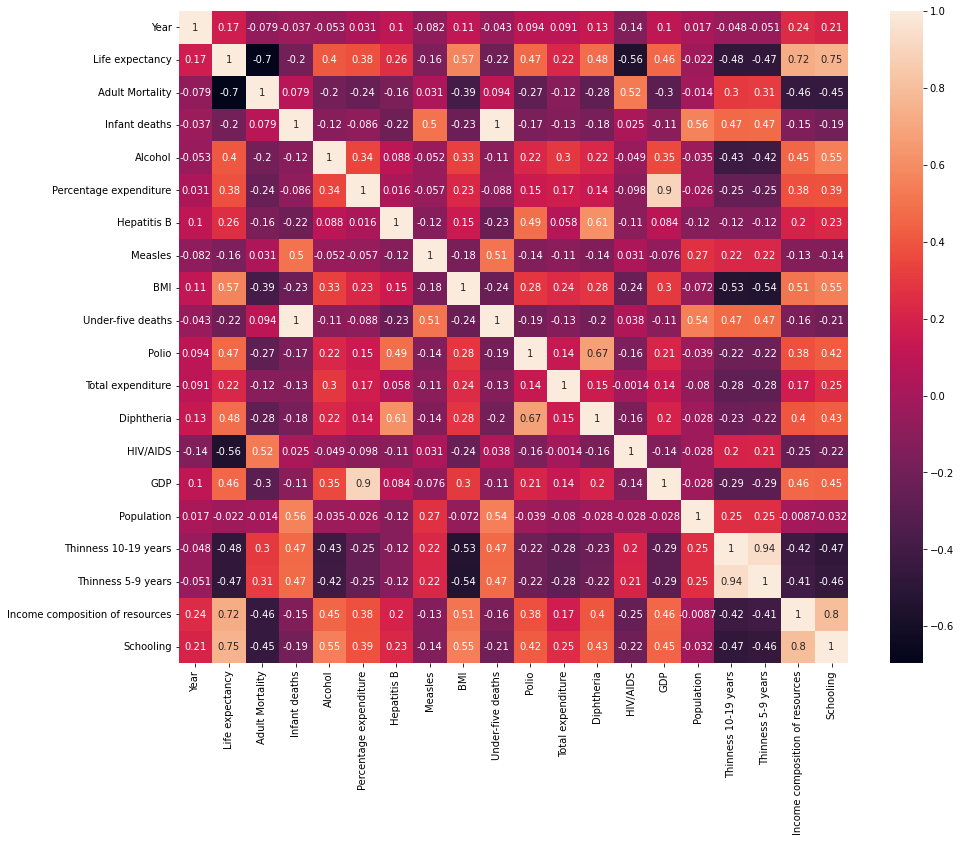

In [8]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(df_raw.corr(), annot=True)

In [9]:
df_raw.drop(columns='Population', inplace=True)  # Due to NaNs & correlation

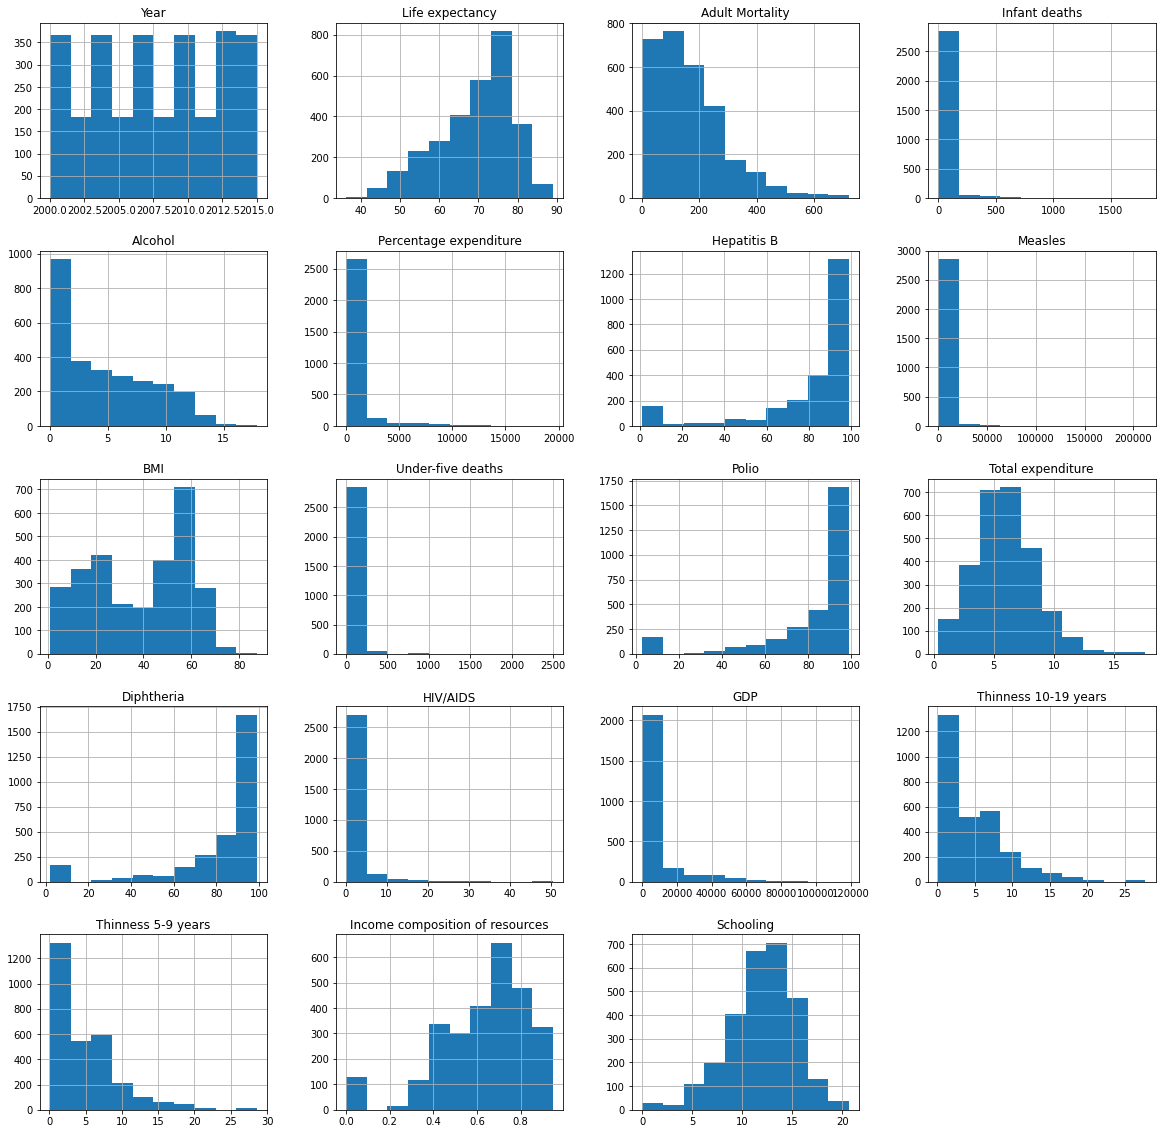

In [10]:
hist = df_raw.hist(figsize=(20, 20))

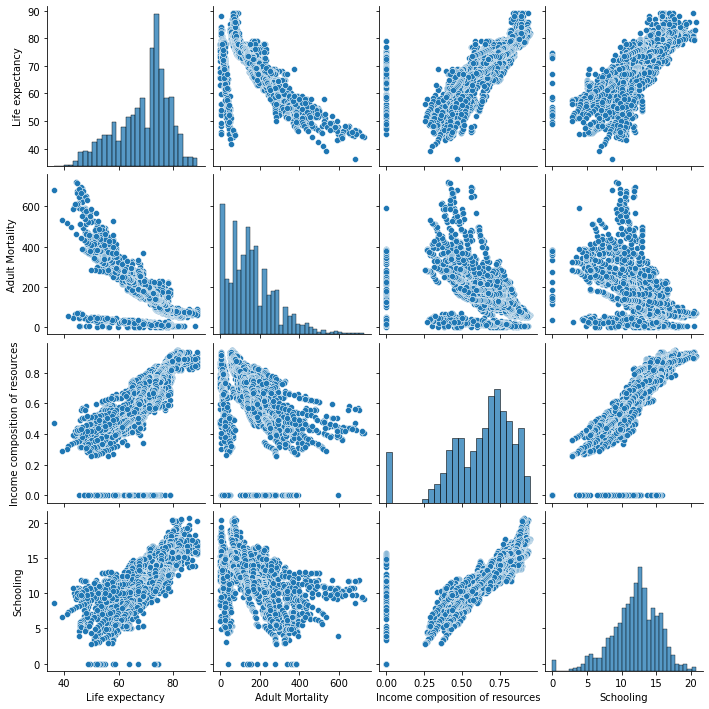

In [11]:
correlations = df_raw.corr().abs()[objective]
columns = [col for col, corr in correlations.items() if corr > 0.6]
ax = sns.pairplot(df_raw[columns])

In [12]:
df_raw.describe().loc[['mean', '50%', 'std']]
# Polio and Schooling are gaussian distributed

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Thinness 10-19 years,Thinness 5-9 years,Income composition of resources,Schooling
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,4.839704,4.870317,0.627551,11.992793
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,3.300000,3.300000,0.677000,12.300000
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,4.420195,4.508882,0.210904,3.358920


In [13]:
df_mean = df_raw.fillna(df_raw.mean())
df_mean_nozero = df_mean[df_mean['Income composition of resources'] != 0]
df_nonan = df_raw.dropna()
df_nonan_nozero = df_nonan[df_nonan['Income composition of resources'] != 0]

dfs = [
    df_mean,
    df_mean_nozero,
    df_nonan,
    df_nonan_nozero
]

#### Apartat B. Regressió

In [14]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

standardize = lambda v: (v - v.mean()) / v.std()

def regression(X, y):
    regr = LinearRegression()
    regr.fit(X, y)
    return regr

In [15]:
standardize = lambda v: (v - v.mean()) / v.std()

In [16]:
def process_df(df, normalize=False):
    """Convert a DataFrame to train and test (X, y)."""
    if normalize:
        df = (df - df.mean()) / df.std()
    train, test = train_test_split(df.select_dtypes(exclude='object'))
    samples = {
        'X_train': train.drop(columns=objective),
        'y_train': train[objective],
        'X_test': test.drop(columns=objective),
        'y_test': test[objective]
    }
    return samples

In [17]:
X_train, y_train, X_test, y_test = process_df(df_mean, normalize=False).values()

In [18]:
model = Pipeline([
    ('feature', SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)),
    ('linear', LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7612890104748381

In [19]:
dict(zip(model[:-1].get_feature_names_out(), model[-1].coef_))

{'Adult Mortality': -0.025381594706663936,
 'HIV/AIDS': -0.5553812830728837,
 'Schooling': 1.4679857470746558}

In [20]:
pred = model.predict(X_test)

{'r2': model.score(X_test, y_test), 'mse' : mse(y_test, pred)}

{'r2': 0.7612890104748381, 'mse': 22.078512977379333}

In [21]:
def train_test_regression(train, test, objective, normalize=True, plot=True):
    if normalize:
        train = (train - train.mean()) / train.std()
        test = (test - test.mean()) / test.std()
    
    y_train, y_test = train[objective], test[objective]
    X_train, X_test = train.drop(columns=objective), test.drop(columns=objective)

    d_mse = {}
    d_r2 = {}

    for attr in X_test:
        x_test = X_test[attr].values[:, None]
        x_train = X_train[attr].values[:, None]

        reg = LinearRegression()
        reg.fit(x_train, y_train)
        pred = reg.predict(x_test)
        
        if plot:
            plt.figure()
            #plt.title(attr)
            plt.scatter(x_test, y_test)
            plt.plot(x_test, pred, 'r')
            plt.ylabel(objective)
            plt.xlabel(attr)
        
        d_mse[attr] = mse(y_test, pred)
        d_r2[attr] = r2_score(y_test, pred)
    
    error = pd.DataFrame([d_mse, d_r2], index=['mse', 'r2']).transpose()

    return error

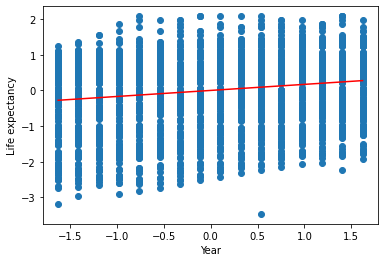

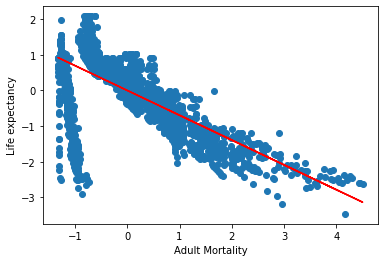

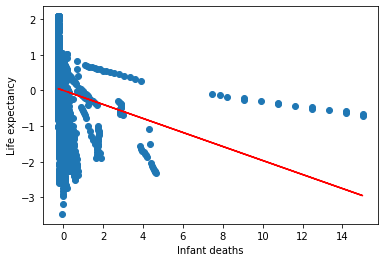

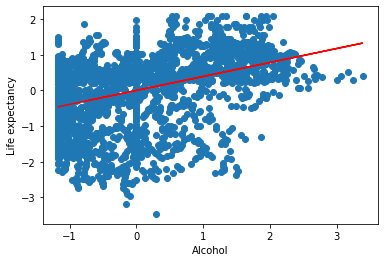

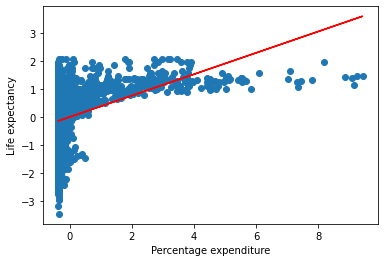

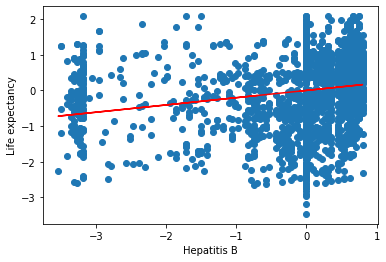

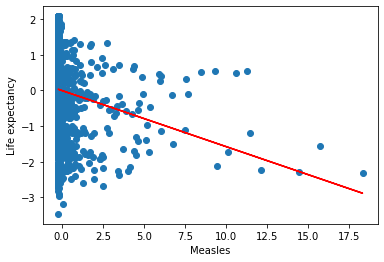

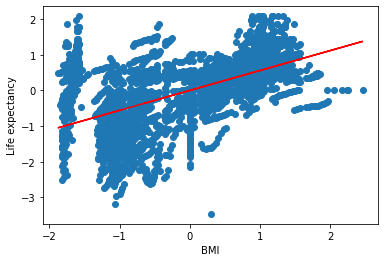

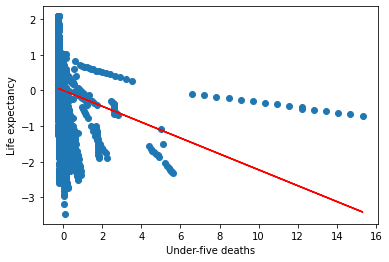

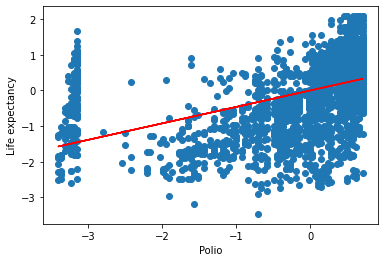

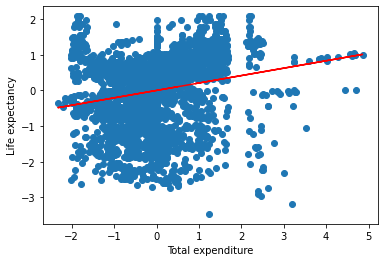

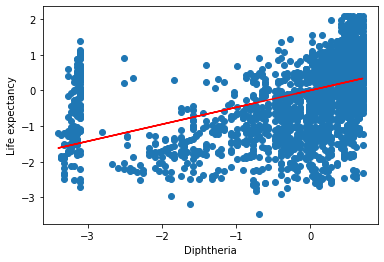

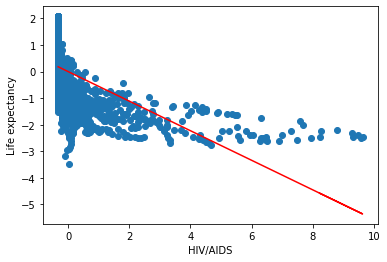

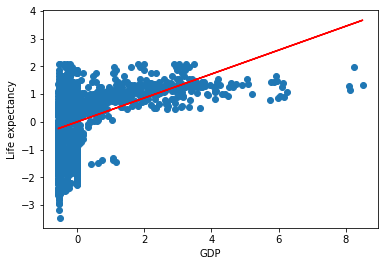

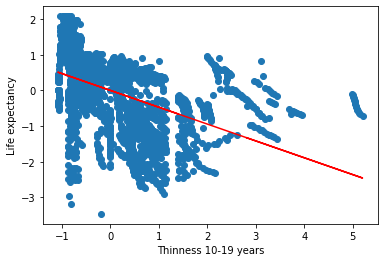

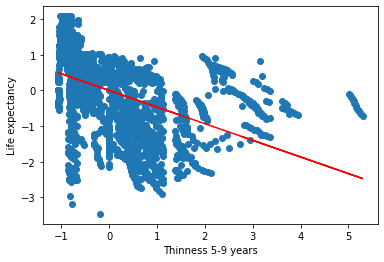

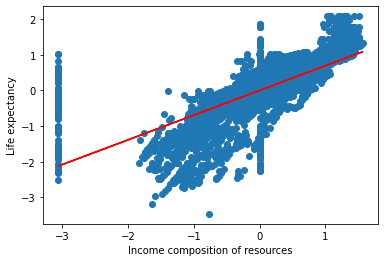

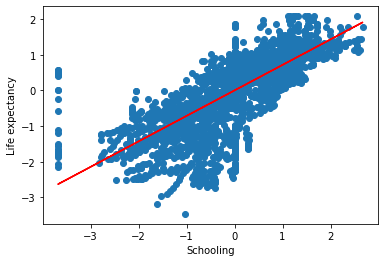

In [22]:
df_mean = df_mean.select_dtypes(exclude='object')
error_mean = train_test_regression(df_mean, df_mean, 'Life expectancy')

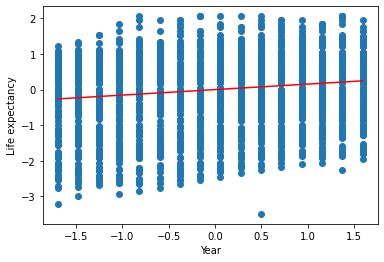

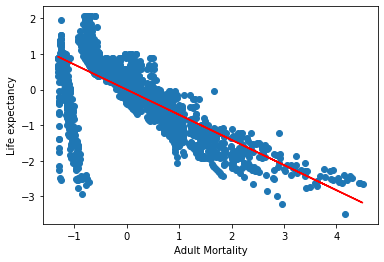

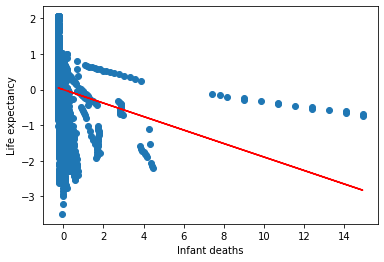

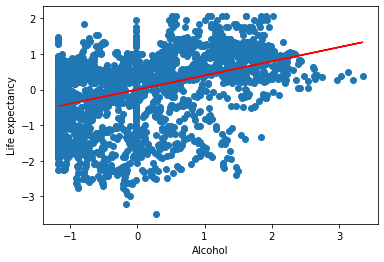

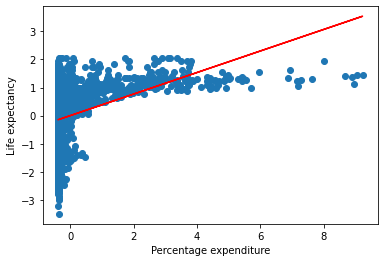

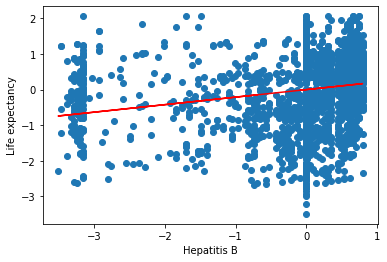

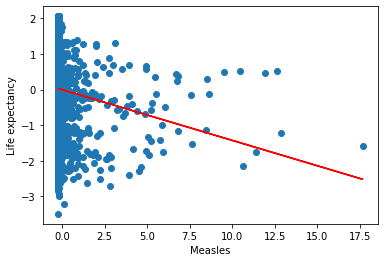

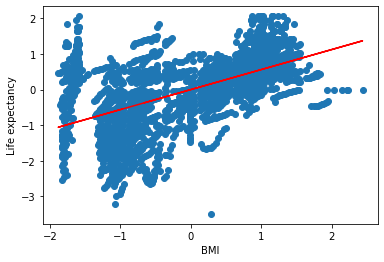

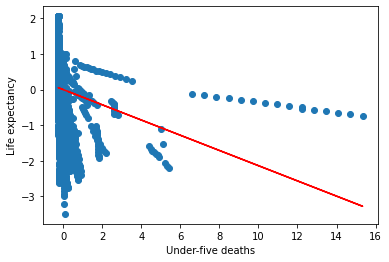

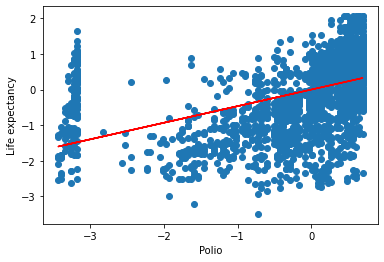

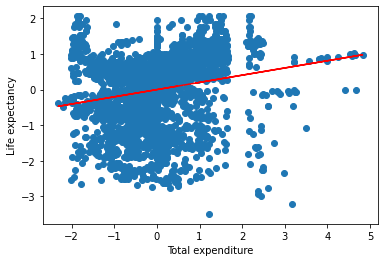

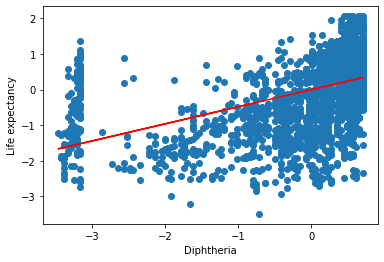

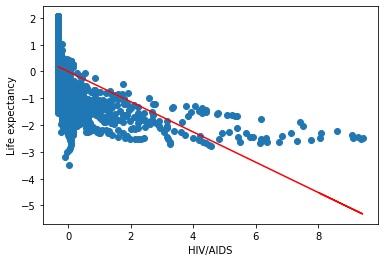

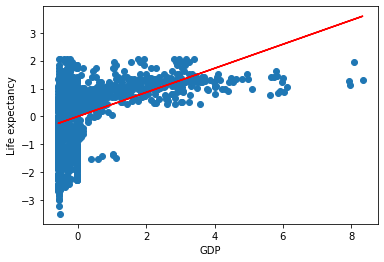

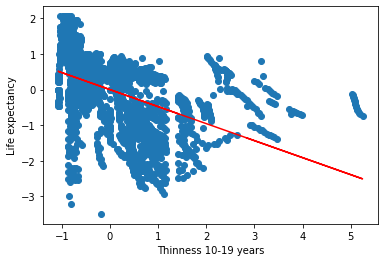

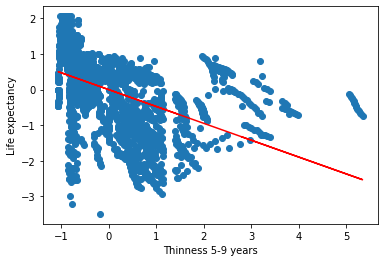

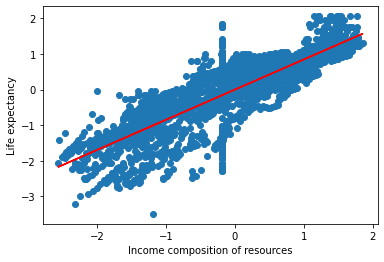

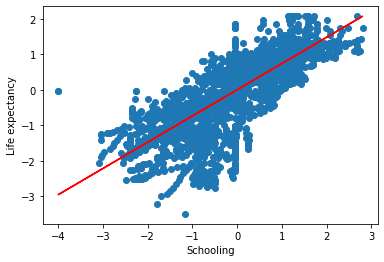

In [23]:
df_mean_nozero = df_mean_nozero.select_dtypes(exclude='object')
error_mean_nozero = train_test_regression(df_mean_nozero, df_mean_nozero, 'Life expectancy')

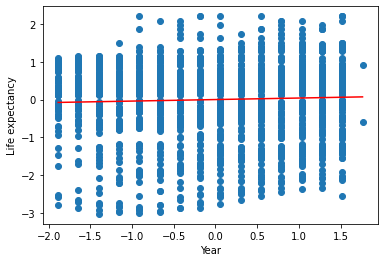

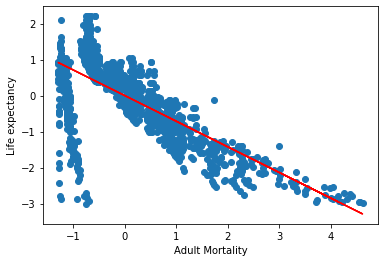

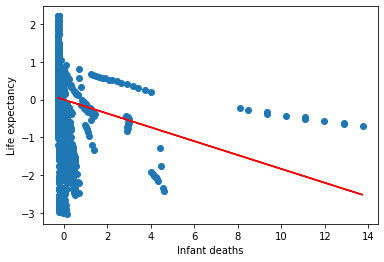

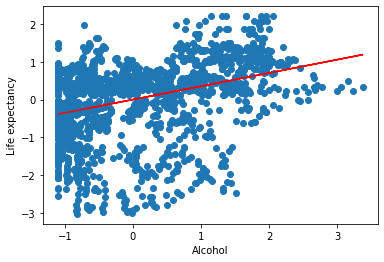

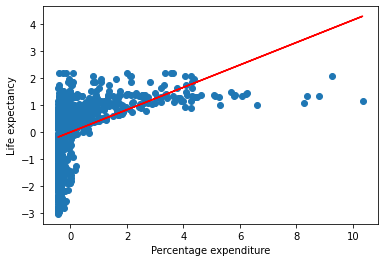

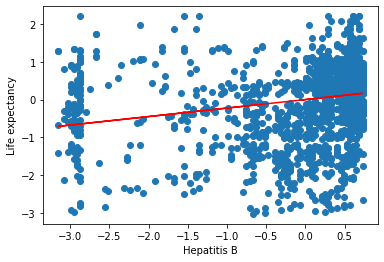

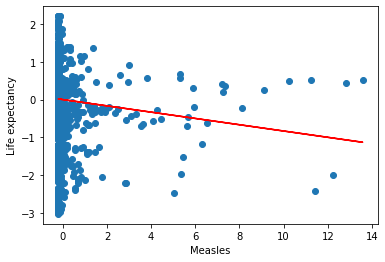

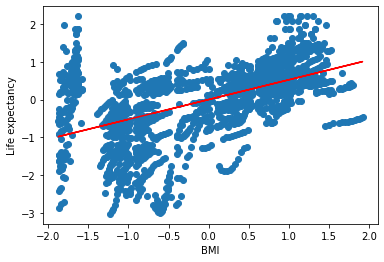

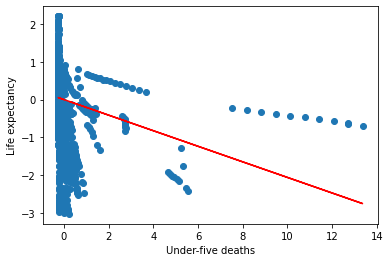

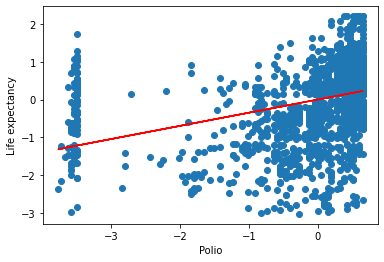

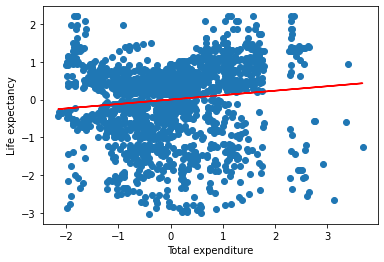

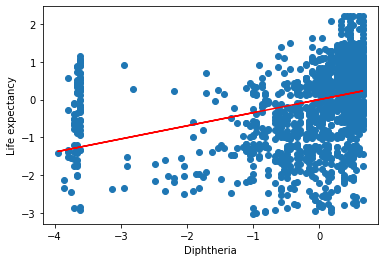

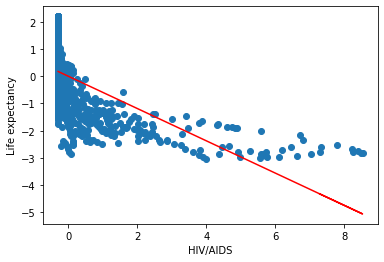

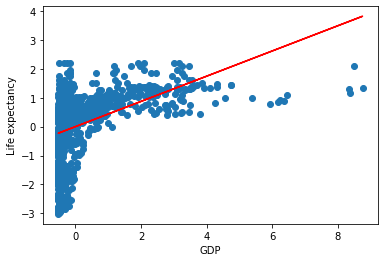

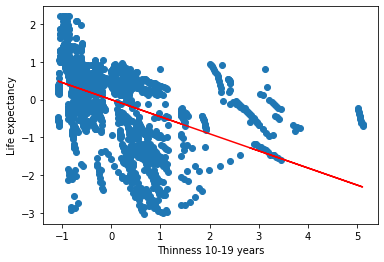

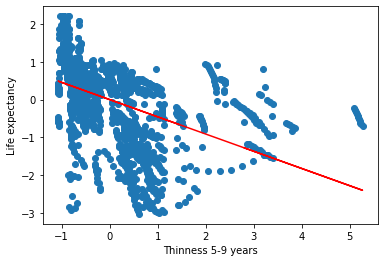

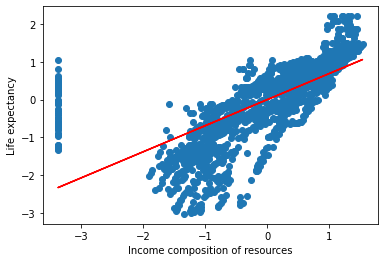

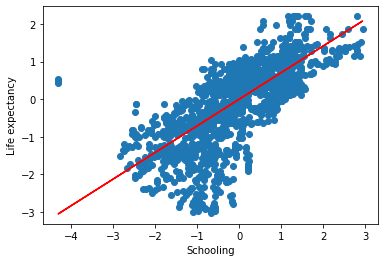

In [24]:
df_nonan = df_nonan.select_dtypes(exclude='object')
error_nonan = train_test_regression(df_nonan, df_nonan, 'Life expectancy')

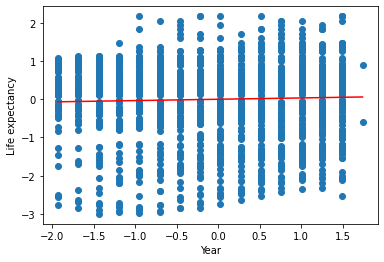

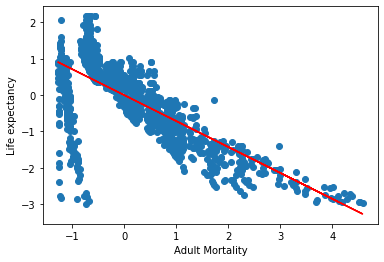

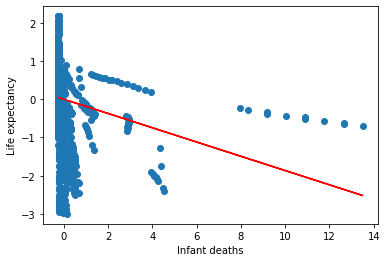

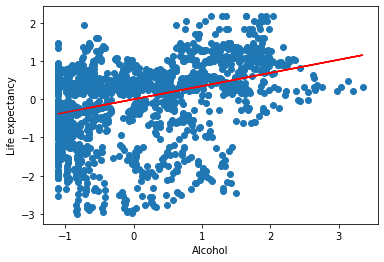

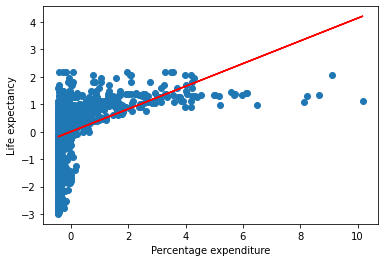

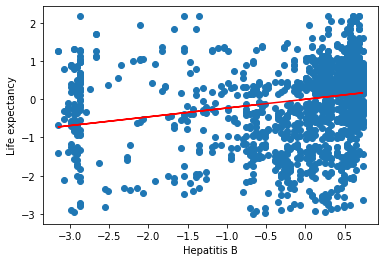

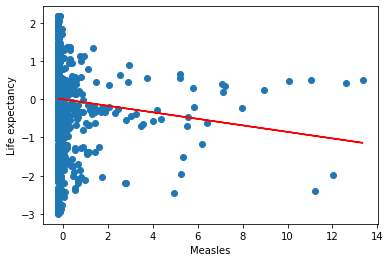

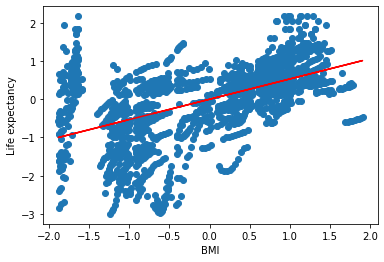

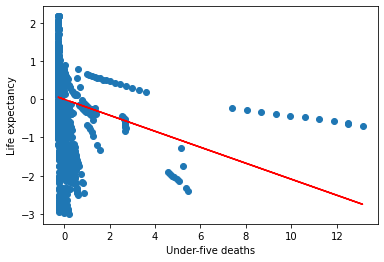

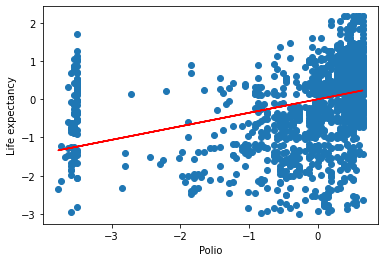

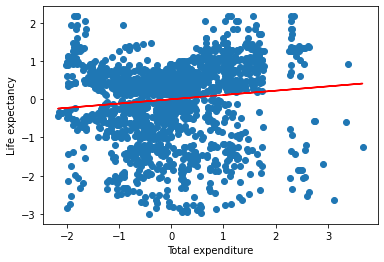

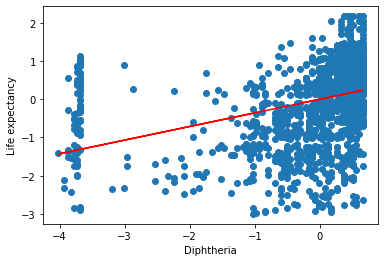

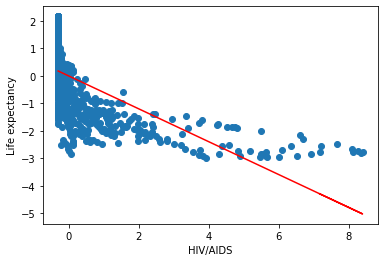

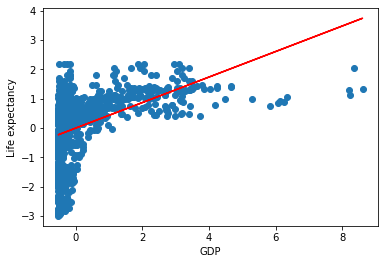

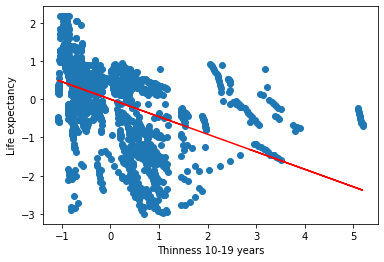

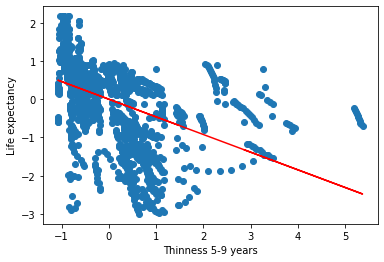

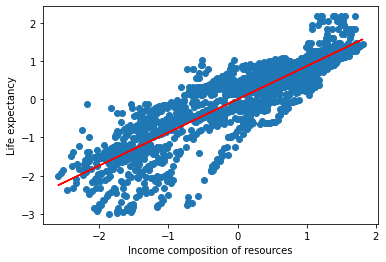

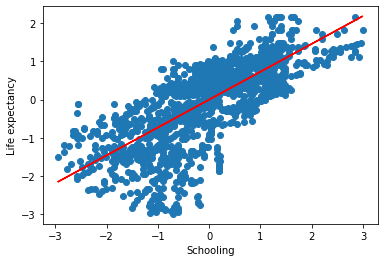

In [25]:
df_nonan_nozero = df_nonan_nozero.select_dtypes(exclude='object')
error_nonan_nozero = train_test_regression(df_nonan_nozero, df_nonan_nozero, 'Life expectancy')

In [26]:
# length = np.isnan(dataset[col].sum()
# dataset[col][np.isnan(dataset[col])] = np.random.normal(dataset[col].mean(), dataset[col].std(), length)

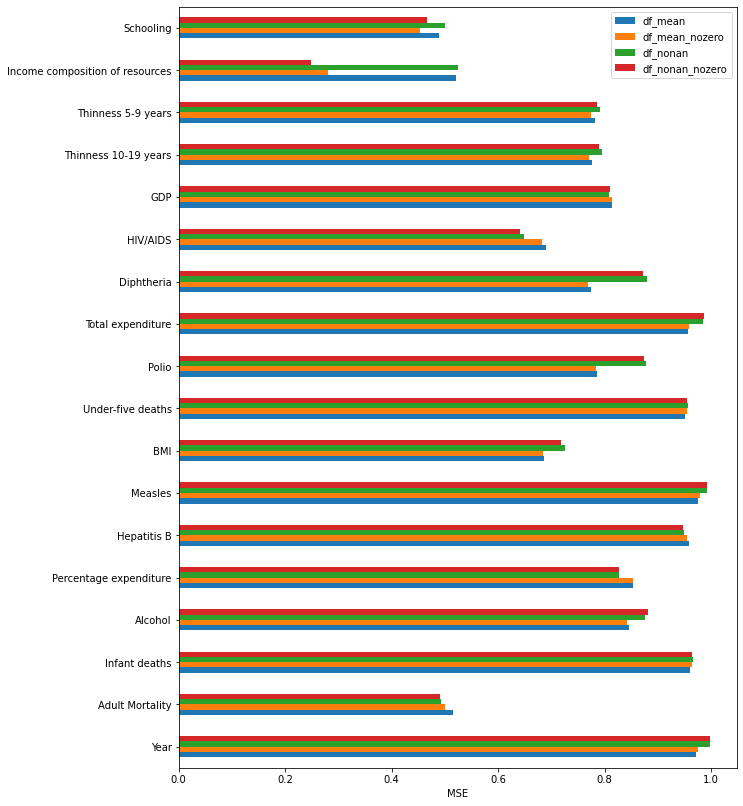

In [27]:
errors_mse = pd.DataFrame(
    [
        error_mean['mse'],
        error_mean_nozero['mse'],
        error_nonan['mse'],
        error_nonan_nozero['mse']
    ],
    index=[
        'df_mean',
        'df_mean_nozero', 
        'df_nonan',
        'df_nonan_nozero'
    ]
).transpose()

errors_mse.plot.barh(figsize=(10, 14))
plt.xlabel('MSE')
plt.show()

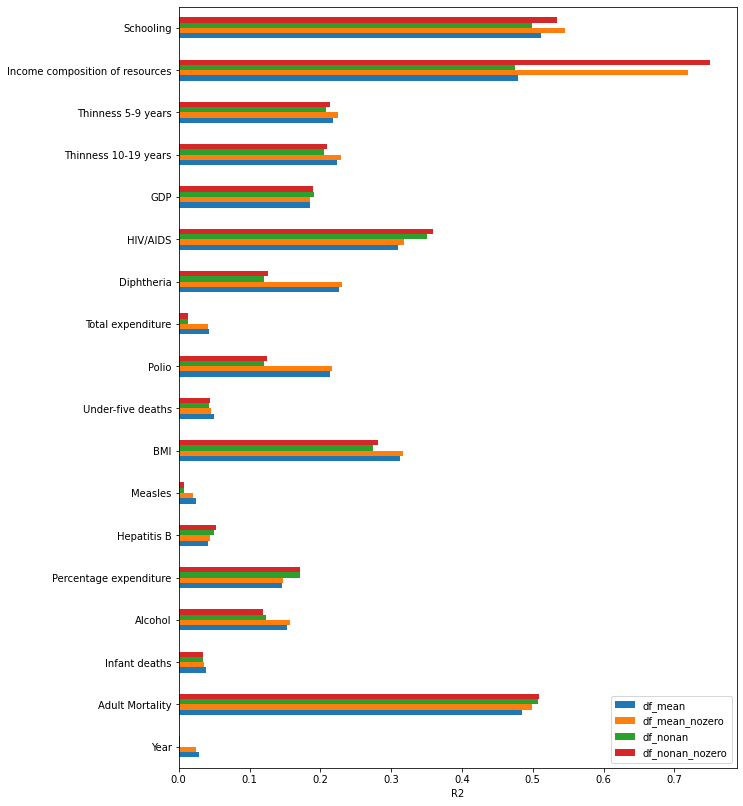

In [28]:
errors_r2 = pd.DataFrame(
    [
        error_mean['r2'],
        error_mean_nozero['r2'],
        error_nonan['r2'],
        error_nonan_nozero['r2']
    ],
    index=[
        'df_mean',
        'df_mean_nozero', 
        'df_nonan',
        'df_nonan_nozero'
    ]
).transpose()

errors_r2.plot.barh(figsize=(10, 14))
plt.xlabel('R2')
plt.show()

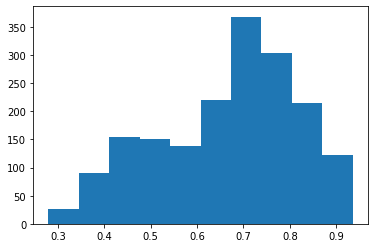

In [29]:
# Mirem si l'atribut 'Income composition of resources' és comporta com una Gaussiana amb les modificacions
icr = df_nonan_nozero['Income composition of resources']
icr.describe().loc[['mean', '50%', 'std']]
plt.hist(icr)
plt.show()

,mse,r2
Income composition of resources,0.250570,0.748728
Schooling,0.469328,0.529357
Adult Mortality,0.502180,0.496413
HIV/AIDS,0.639440,0.358768
BMI,0.754780,0.243105
Percentage expenditure,0.799271,0.198490
Thinness 5-9 years,0.799683,0.198077
GDP,0.806594,0.191146
Thinness 10-19 years,0.807311,0.190428
Polio,0.847319,0.150308


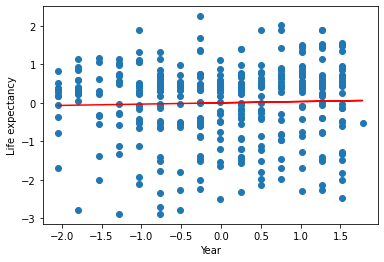

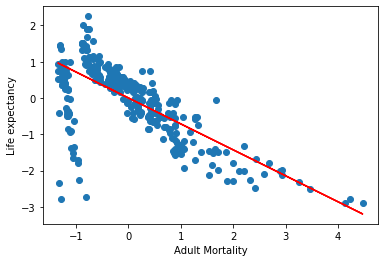

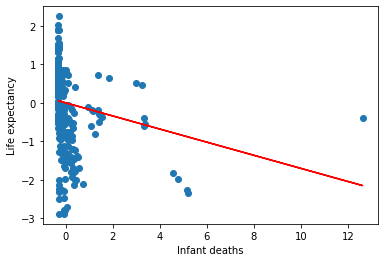

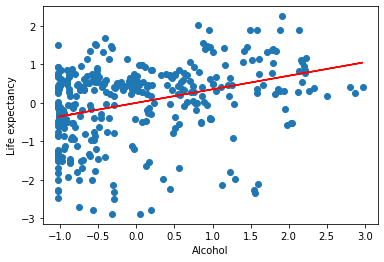

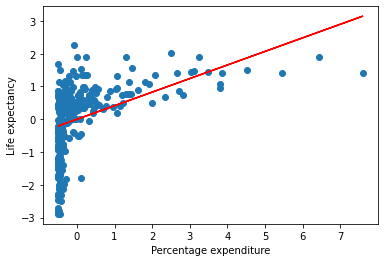

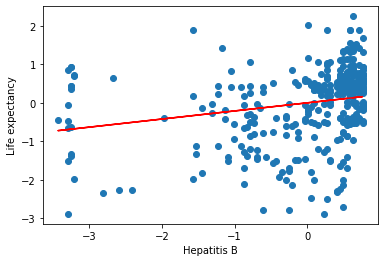

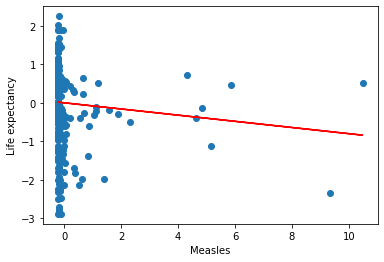

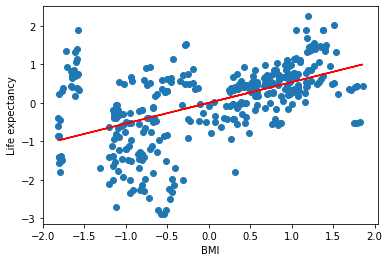

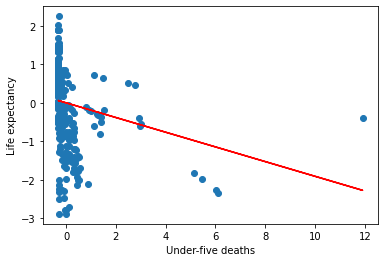

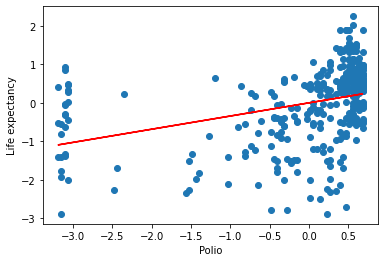

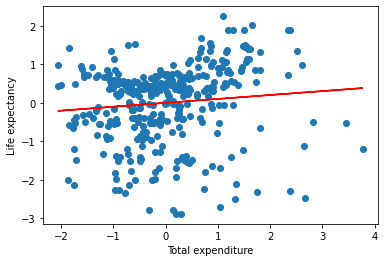

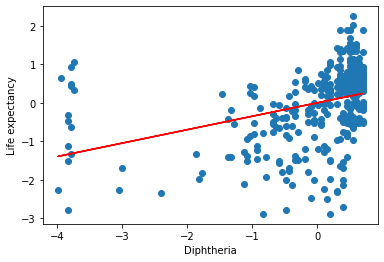

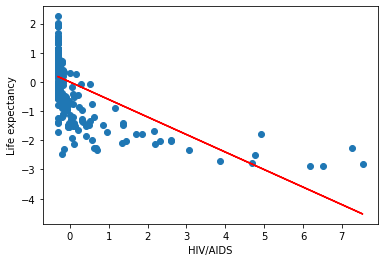

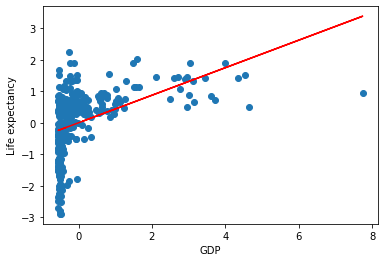

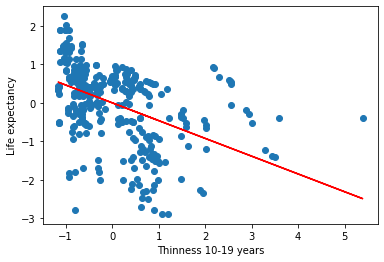

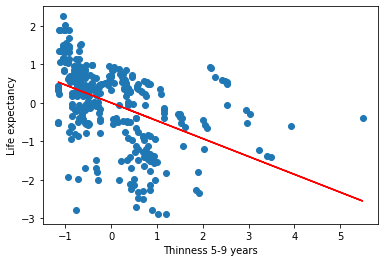

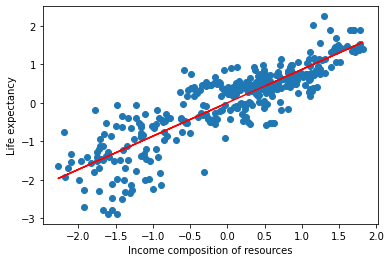

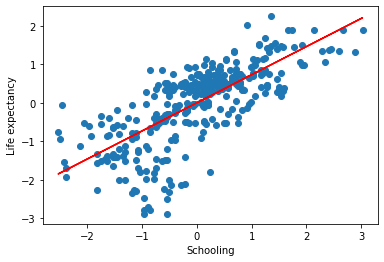

In [30]:
train, test = train_test_split(df_nonan_nozero, test_size=0.2)
error = train_test_regression(train, test, 'Life expectancy')
error.sort_values(by='r2', ascending=False)

In [31]:
df_PCA = df_mean.copy(deep=True)
df_PCA = df_PCA.select_dtypes(exclude='object')
df_PCA = standardize(df_PCA)
df_PCA.dropna(inplace=True)

X = df_PCA.drop(columns='Life expectancy')

components = 3
pca = PCA(n_components=components)
principal_components = pca.fit_transform(X)
principal_components

df_PCA = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i}' for i in range(components)]
)

df_PCA['Life expectancy'] = df_mean['Life expectancy']


#### Apartat A. Descens del gradient

In [32]:
class Regressor:

    def __init__(self, alpha=0.01, max_iter=1000, epsilon=0.001, l=0.1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.cost = 10000
        self.l = l

    def predict(self, X):
        return np.dot(X, self.weights) + self.w0

    def __update(self, X, y, hy):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        loss = hy - y
        m = y.shape[0]

        gradient = np.dot(loss, X)
        self.weights -= self.alpha*gradient/m - self.l*self.weights/m
        self.w0 -= self.alpha*np.sum(loss)/m
        self.cost = (np.sum(loss**2) + self.l*np.sum(self.weights**2))/ (2*m)

    def train(self, X, y):
        it = 0
        self.w0 = 1
        self.weights = np.ones(X.shape[1])
        while it < self.max_iter and self.cost > self.epsilon:
            hy = self.predict(X)
            self.__update(X, y, hy)
            
            it += 1
            # if not it % 50:
            #     print(f'cost: {self.cost}, w0: {self.w0}, w: {self.weights}')
        print(f'w0: {self.w0}, w: {self.weights}')
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon

In [33]:
# Gradient descent PCA
X_train, y_train, X_test, y_test = process_df(df_PCA, normalize=True).values()
reg = Regressor(alpha=0.05, max_iter=5000)
reg.train(X_train, y_train)
pred = reg.predict(X_test)
print(mse(y_test, pred))
print(r2_score(y_test, pred))
#en el nostre cas, reduint les dimensions amb les que treballem no ens millora el model resultant

w0: 0.006938066131990494, w: [-0.781  0.278 -0.136]
0.2965940004716316
0.7044818501367491


In [34]:
df_descent = df_nonan_nozero[[
    'Adult Mortality',
    'HIV/AIDS',
    'Income composition of resources',
    'Life expectancy'
]]
X_train, y_train, X_test, y_test = process_df(df_descent, normalize=True).values()
reg = Regressor(alpha=0.05, max_iter=5000, l=0.5)
reg.train(X_train, y_train)
pred = reg.predict(X_test)
#per fer l'informe mirar link discord l2_regularització per escollir valor l

#error = train_test_regression(train, test, 'Life expectancy')
#print(error)
print(mse(y_test, pred))
print(r2_score(y_test, pred))

w0: -0.0017528638946270605, w: [-0.193 -0.256  0.66 ]
0.12504631249330228
0.8826760822529134


In [35]:
model[-1].intercept_

56.69781381337066

Adult Mortality': -0.014927077430426138,
 'HIV/AIDS': -0.37240701348032945,
 'Income composition of resources'

In [36]:
poly = PolynomialFeatures(2, include_bias=False)
X_train, y_train, X_test, y_test = process_df(df_descent, normalize=True).values()

X_train = poly.fit_transform(X_train, y_train)
X_test = poly.fit_transform(X_test)

reg = Regressor(alpha=0.01, max_iter=1000, l=0.02)
reg.train(X_train, y_train)
pred = reg.predict(X_test)

mse(y_test, pred), r2_score(y_test, pred)

dict(zip(
    poly.get_feature_names_out(['Adult Mortality', 'HIV/AIDS', 'Income composition of resources']),
    reg.weights
))

w0: 0.14548422304242015, w: [-0.198  0.374  0.791 -0.176  0.084 -0.073 -0.033  0.291  0.078]


{'Adult Mortality': -0.1976435365803474,
 'HIV/AIDS': 0.3741522651514186,
 'Income composition of resources': 0.7905736933919243,
 'Adult Mortality^2': -0.17560419373737438,
 'Adult Mortality HIV/AIDS': 0.08362370828361153,
 'Adult Mortality Income composition of resources': -0.07319616824826228,
 'HIV/AIDS^2': -0.0328532881245068,
 'HIV/AIDS Income composition of resources': 0.2907757868599304,
 'Income composition of resources^2': 0.07833000491217422}

In [37]:
#comparem amb el descens de gradient de la llibreria sklearn
from sklearn.linear_model import SGDRegressor
X_train, y_train, X_test, y_test = process_df(df_descent, normalize=True).values()
clf = SGDRegressor(penalty="l2", max_iter=5000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(mse(y_test, pred))
print(r2_score(y_test, pred))

0.14653412482085004
0.8706536547775687


w0: -0.013830946910886406, w: [0.878]
0.24900399464580097 0.7276963184892269


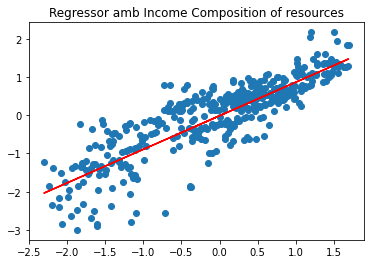

In [38]:
#plot en 2d
X= df_descent.drop(columns=['HIV/AIDS', 'Adult Mortality'])
X_train, y_train, X_test, y_test = process_df(X, normalize=True).values()
reg = Regressor(alpha=0.05, max_iter=5000, l=0.5)
reg.train(X_train, y_train)
pred = reg.predict(X_test)
plt.figure()
plt.title('Regressor amb Income Composition of resources')
plt.scatter(X_test, y_test)
plt.plot(X_test, pred, 'r')
print(mse(y_test, pred), r2_score(y_test, pred))


w0: -0.005594058547625513, w: [-0.312  0.703]
mse = 0.1607450737395284, r2 = 0.8333112093908848
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


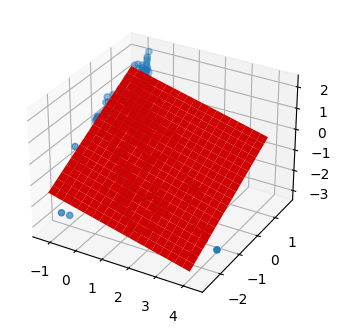

In [39]:
# %matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
X = df_descent.drop(columns='HIV/AIDS')

X_train, y_train, X_test, y_test = process_df(X, normalize=True).values()
# x_val = df_descent.drop(columns=['Life expectancy', 'HIV/AIDS'])
# y_val = df_descent['Life expectancy']
# X_train, y_train, X_test, y_test = process_df(df_descent.drop(columns='HIV/AIDS'), normalize=True).values()
regr = Regressor(alpha=0.1, max_iter=1000, l=0.5)
regr.train(X_train, y_train)
predX3D = regr.predict(X_test)

mse_metric, r2_score_metric = mse(y_test, predX3D), r2_score(y_test, predX3D)
print(f'mse = {mse(y_test, predX3D)}, r2 = {r2_score(y_test, predX3D)}')


# Afegim els 1's
A = np.hstack((X_test,np.ones([X_test.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

X_test = X_test.to_numpy()

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(X_test[:,0]) - min(X_test[:,0]))/2 + min(X_test[:,0])
malla_x2 =  malla * (max(X_test[:,1]) - min(X_test[:,1]))/2 + min(X_test[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)


#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(X_test[:,0],X_test[:,1],y_test)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d39a29cb-b9dc-42f0-9dea-b7ab200c4080' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>